<a href="https://colab.research.google.com/github/varshika15/SARIMA-model/blob/master/Sarima_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
%matplotlib inline
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore') #to ignore if any warnings takes place during the run time.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train = pd.read_csv('/content/train.csv')
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")

In [3]:
train_df = train[train['store']==1]
train_df = train_df[train['item']==1]
train_df['year'] = train['date'].dt.year
train_df['month'] = train['date'].dt.month
train_df['day'] = train['date'].dt.dayofyear

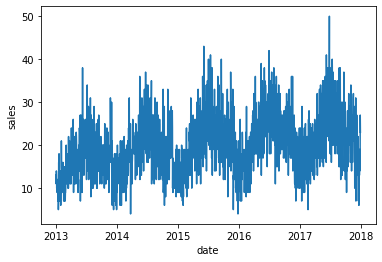

In [4]:
sns.lineplot(x="date", y="sales",legend = 'full' , data=train_df)

In [5]:
train_df = train_df.set_index('date')
train_df['sales'] = train_df['sales'].astype(float)

In [6]:
train_df.head()

,store,item,sales,year,month,day
date,,,,,,
2013-01-01,1,1.0,13.0,2013,1,1
2013-01-02,1,1.0,11.0,2013,1,2
2013-01-03,1,1.0,14.0,2013,1,3
2013-01-04,1,1.0,13.0,2013,1,4
2013-01-05,1,1.0,10.0,2013,1,5


<Figure size 432x288 with 0 Axes>

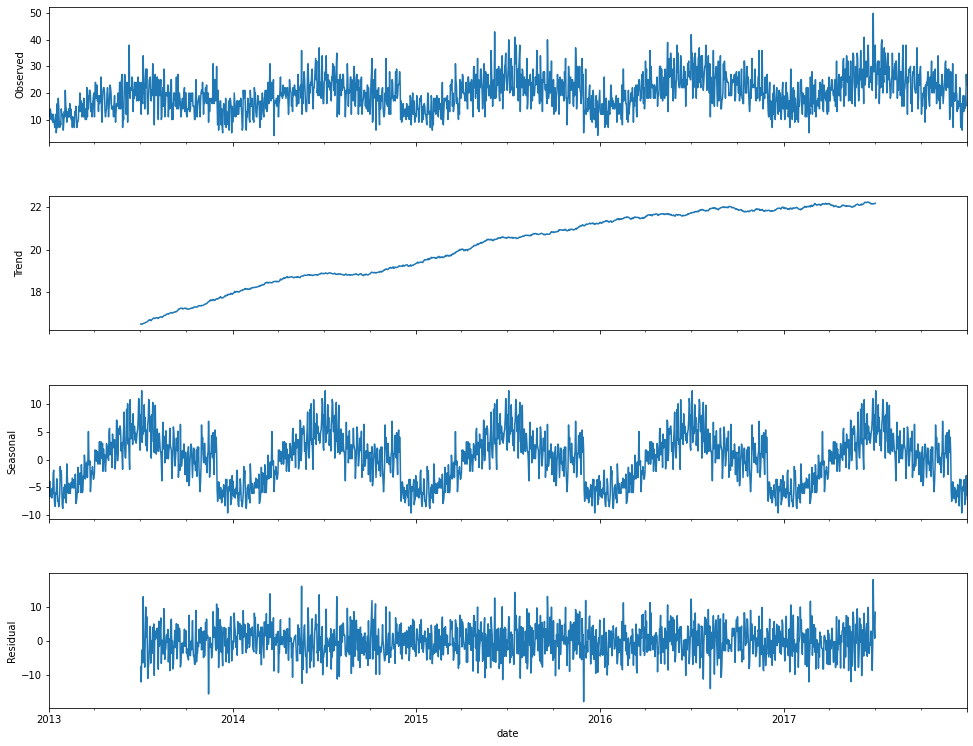

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(train_df['sales'], model='additive', freq=365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

In [10]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    #Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [11]:
test_stationarity(train_df['sales'])

Results of Dickey-Fuller Test:
p-value = 0.0361. The series is likely non-stationary.
Test Statistic                   -2.987278
p-value                           0.036100
#Lags Used                       20.000000
Number of Observations Used    1805.000000
Critical Value (1%)              -3.433978
Critical Value (5%)              -2.863143
Critical Value (10%)             -2.567623
dtype: float64


In [12]:
first_diff = train_df.sales - train_df.sales.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.520810e+01
p-value                        5.705031e-28
#Lags Used                     2.000000e+01
Number of Observations Used    1.804000e+03
Critical Value (1%)           -3.433980e+00
Critical Value (5%)           -2.863143e+00
Critical Value (10%)          -2.567624e+00
dtype: float64


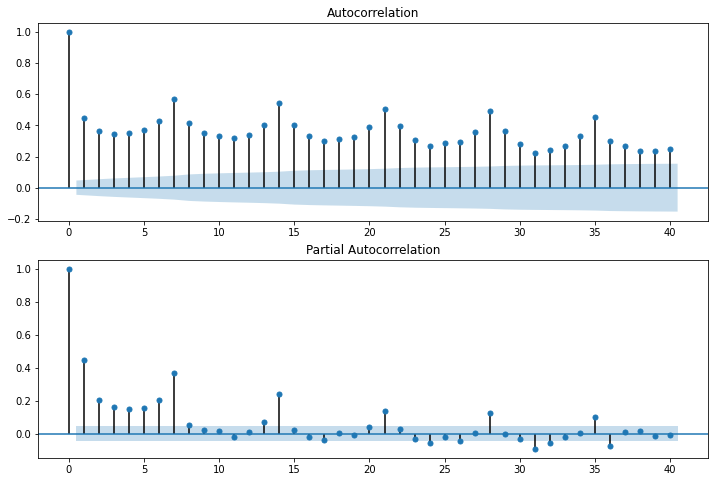

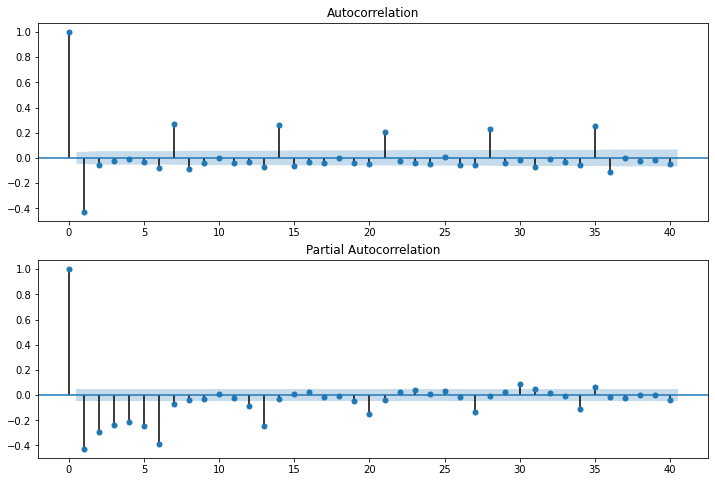

In [13]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.sales, lags=40, ax=ax1)  
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df.sales, lags=40, ax=ax2)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

In [15]:
arima_mod = sm.tsa.ARIMA(train_df.sales, (6,1,0)).fit(disp=False)
print(arima_mod.summary())

from scipy import stats
from scipy.stats import normaltest

resid_arima = arima_mod.resid
print(normaltest(resid_arima))

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Sun, 12 Jul 2020   AIC                          11211.335
Time:                        09:57:25   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

In [16]:
sarima_mod = sm.tsa.statespace.SARIMAX(train_df.sales, trend='n', order=(6,1,0)).fit()
print(sarima_mod.summary())

from scipy import stats
from scipy.stats import normaltest

resid_sarima = sarima_mod.resid
print(normaltest(resid_sarima))

                           Statespace Model Results                           
Dep. Variable:                  sales   No. Observations:                 1826
Model:               SARIMAX(6, 1, 0)   Log Likelihood               -5597.679
Date:                Sun, 12 Jul 2020   AIC                          11209.359
Time:                        09:57:48   BIC                          11247.924
Sample:                    01-01-2013   HQIC                         11223.585
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8174      0.021    -39.063      0.000      -0.858      -0.776
ar.L2         -0.7497      0.025    -30.480      0.000      -0.798      -0.702
ar.L3         -0.6900      0.026    -26.686      0.0

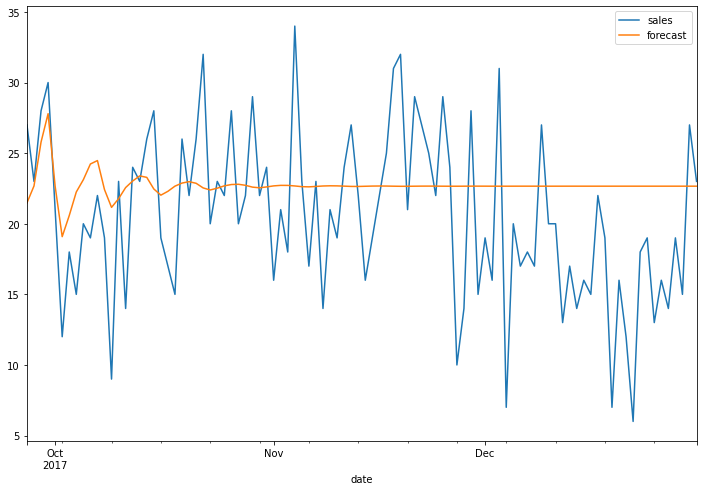

In [17]:
start_index = 1730
end_index = 1826
train_df['forecast'] = sarima_mod.predict(start = start_index, end= end_index, dynamic= True)  
train_df[start_index:end_index][['sales', 'forecast']].plot(figsize=(12, 8))

In [91]:
def smape(y_true, y_pred):
    mape = np.mean(abs((y_true-y_pred)/y_true))*100
    smape = np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))).fillna(0))
    print('MAPE: %.2f %% \nSMAPE: %.2f'% (mape,smape), "%")

In [19]:
smape(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast'])

MAPE: 33.01 % 
SMAPE: 25.07 %


In [20]:
train_df = train[train['store']==1]
train_df = train_df[train_df['item']==1]

train_df['year'] = train_df['date'].dt.year - 2012
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.dayofyear

start_index = 1730
end_index = 1826

In [74]:
holiday = pd.read_csv('/content/datasets_holidays.csv')
holiday['date'] = pd.to_datetime(holiday['Date'], yearfirst = True)
holiday['holiday'] = holiday['Holiday']
holiday.drop('Date', axis=1, inplace=True)
holiday.drop('Holiday', axis=1, inplace=True)
holiday.drop('Unnamed: 0', axis=1, inplace=True)
holiday = holiday.set_index('date')


,holiday
date,
2010-12-31,New Year's Day
2011-01-17,"Birthday of Martin Luther King, Jr."
2011-02-21,Washington's Birthday
2011-05-30,Memorial Day
2011-07-04,Independence Day


In [77]:
train_df = train_df.merge(holiday, how='left', on='date')
#train_df['holiday_bool'] = pd.notnull(train_df['holiday']).astype(int)
#train_df = pd.get_dummies(train_df, columns = ['month'] )
train_df.head()

,date,store,item,sales,year,day,Unnamed: 0_x,Date_x,Holiday_x,holiday_x,holiday_bool,Unnamed: 0_y,Date_y,Holiday_y,holiday_y,holiday_x,holiday_y,holiday_x,forecast_sarimax,holiday_y,holiday_x,holiday_y,holiday_x,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_y,holiday_x,holiday_y,holiday_x,holiday_y,holiday_x,holiday_y,holiday
0,2013-01-01,1,1.0,13.0,1,1,20.0,2013-01-01,New Year's Day,New Year's Day,1,20.0,2013-01-01,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,NaN,New Year's Day,New Year's Day,New Year's Day,New Year's Day,1,0,0,0,0,0,0,0,0,0,0,0,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day
1,2013-01-02,1,1.0,11.0,1,2,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1.0,14.0,1,3,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1.0,13.0,1,4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1.0,10.0,1,5,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
ext_var_list = ['date','year', 'day', 'holiday_bool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']

In [83]:
exog_data = train_df[ext_var_list]
exog_data = exog_data.set_index('date')
exog_data.head()

,year,day,holiday_bool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
date,,,,,,,,,,,,,,,
2013-01-01,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-02,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-03,1,3,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-04,1,4,0,1,0,0,0,0,0,0,0,0,0,0,0
2013-01-05,1,5,0,1,0,0,0,0,0,0,0,0,0,0,0


In [85]:
train_df = train_df.set_index('date')
# train_df = train_df.reset_index()
train_df.head()

,store,item,sales,year,day,Unnamed: 0_x,Date_x,Holiday_x,holiday_x,holiday_bool,Unnamed: 0_y,Date_y,Holiday_y,holiday_y,holiday_x,holiday_y,holiday_x,forecast_sarimax,holiday_y,holiday_x,holiday_y,holiday_x,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,holiday_y,holiday_x,holiday_y,holiday_x,holiday_y,holiday_x,holiday_y,holiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,1,1.0,13.0,1,1,20.0,2013-01-01,New Year's Day,New Year's Day,1,20.0,2013-01-01,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,NaN,New Year's Day,New Year's Day,New Year's Day,New Year's Day,1,0,0,0,0,0,0,0,0,0,0,0,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day,New Year's Day
2013-01-02,1,1.0,11.0,1,2,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,1,1.0,14.0,1,3,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,1,1.0,13.0,1,4,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-05,1,1.0,10.0,1,5,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
start_index = '2017-10-01'
end_index = '2017-12-31'

In [87]:
%%time
sarimax_mod = sm.tsa.statespace.SARIMAX(endog = train_df.sales[:start_index],
                                          exog = exog_data[:start_index], 
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
print(sarimax_mod.summary())

                                 Statespace Model Results                                
Dep. Variable:                             sales   No. Observations:                 1735
Model:             SARIMAX(6, 1, 0)x(0, 1, 1, 7)   Log Likelihood               -5134.093
Date:                           Sun, 12 Jul 2020   AIC                          10314.186
Time:                                   11:48:37   BIC                          10439.631
Sample:                               01-01-2013   HQIC                         10360.589
                                    - 10-01-2017                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
year          -526.2587   1485.445     -0.354      0.723   -3437.677    2385.159
day             -1.4383      4.067   

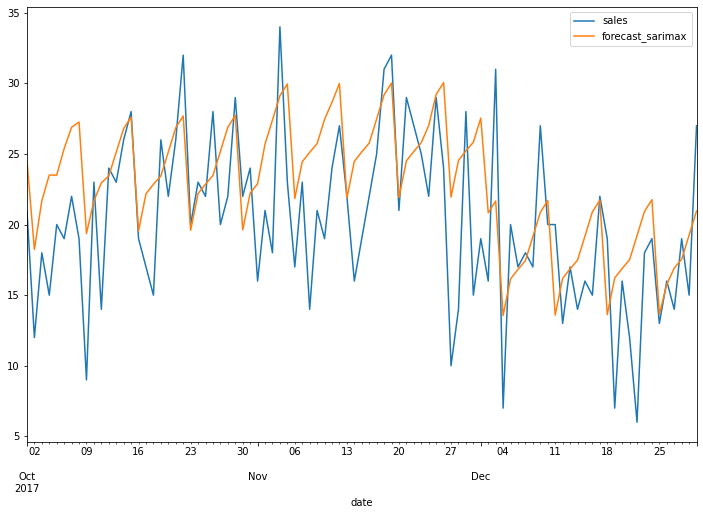

In [89]:
start_index = '2017-10-01'
end_index = '2017-12-30'
end_index1 = '2017-12-31'

train_df['forecast_sarimax'] = sarimax_mod.predict(start = pd.to_datetime(start_index), end= pd.to_datetime(end_index1),
                                                   exog = exog_data[start_index:end_index], 
                   dynamic= True)  

train_df[start_index:end_index][['sales', 'forecast_sarimax']].plot(figsize=(12, 8))

In [93]:
smape(train_df[1730:1825]['sales'],train_df[1730:1825]['forecast_sarimax'])

MAPE: 27.45 % 
SMAPE: 21.01 %
